In [115]:
###############
## Libraries ##
###############

import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
from tensorflow.keras import datasets, layers, models, losses
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import backend as K
from tensorflow import keras

# Training the Model

In [116]:
##########################
## Load in MNIST Digits ##
##########################

all_data = np.load("/scratch/gpfs/eysu/src_data/mnist.npz")
print(all_data.files)
x_test = all_data['x_test']
x_train = all_data['x_train']
y_train = all_data['y_train']
y_test = all_data['y_test']

print(x_test.shape)
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)

# examine
# print(x_train)
# print(x_test)
# print(y_train)
# print(y_test)

['x_test', 'x_train', 'y_train', 'y_test']
(10000, 28, 28)
(60000, 28, 28)
(60000,)
(10000,)


In [117]:
###############################
## Partition and resize data ##
###############################

labels = ["0",  # index 0
          "1",  # index 1
          "2",  # index 2 
          "3",  # index 3 
          "4",  # index 4
          "5",  # index 5
          "6",  # index 6 
          "7",  # index 7 
          "8",  # index 8 
          "9"]  # index 9

# save train labels
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


# y_train_labels = y_train
# y_test_labels = y_test

# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train[5000:], np.array(y_train[:5000]).squeeze()

# Reshape input data from (28, 28) to (28, 28, 1)
w, h = 28, 28
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)


# Pretrain the model on a few of the labels

In [118]:
######################################################
## PRETRAINING STEP 1: isolate a subset of the data ##
######################################################

## Subset = digits 0-6

y_train_subset = y_train[y_train < 10]
x_train_subset = x_train[y_train_subset]

y_valid_subset = y_valid[y_valid < 10]
x_valid_subset = x_valid[y_valid_subset]

y_test_subset = y_test[y_test < 10]
x_test_subset = x_test[y_test_subset]

# examine
print(y_train_subset.shape)
print(np.unique(y_train_subset, return_counts = True))
print(y_train_subset)
print(x_train_subset.shape)

print(y_valid_subset.shape)
print(np.unique(y_valid_subset, return_counts = True))
print(y_valid_subset)
print(x_valid_subset.shape)

print(y_test_subset.shape)
print(np.unique(y_test_subset, return_counts = True))
print(y_test_subset)
print(x_test_subset.shape)


(55000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5444, 6179, 5470, 5638, 5307, 4987, 5417, 5715, 5389, 5454]))
[7 3 4 ... 5 6 8]
(55000, 28, 28, 1)
(5000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([479, 563, 488, 493, 535, 434, 501, 550, 462, 495]))
[5 0 4 ... 2 1 2]
(5000, 28, 28, 1)
(10000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))
[7 2 1 ... 4 5 6]
(10000, 28, 28, 1)


In [77]:
###################################################
## PRETRAINING STEP 2: train data on data subset ##
###################################################
# Define the model: a small CNN model
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
# model.summary()

# Number of epochs per training run
EPOCHS = 5
# Where to store output model weights and softmax predictions
save_path = "/scratch/gpfs/eysu/low_shot_weights/"

# fix dimensions
y_train_subset = tf.keras.utils.to_categorical(y_train_subset, 10)
y_valid_subset = tf.keras.utils.to_categorical(y_valid_subset, 10)
y_test_subset = tf.keras.utils.to_categorical(y_test_subset, 10)

print(y_train_subset.shape)
print(np.unique(y_train_subset, return_counts = True))
# print(y_train_subset)

print(y_valid_subset.shape)
print(np.unique(y_valid_subset, return_counts = True))
# print(y_valid_subset)

print(y_test_subset.shape)
print(np.unique(y_test_subset, return_counts = True))
# print(y_test_subset)

print(np.unique(np.where(y_train_subset ==1)[1]))

mpth = 'model.weights.best.pretrain.hdf5'
y_hat_test_name = 'y_hat_test_pretrain'
y_hat_train_name = 'y_hat_train_pretrain'


# define optimization and energy parameters
# set learning rate and exponential decay rate *** BORROWING FROM INTERLEAVING PAPER **** , 
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1 =0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Save checkpoints
checkpointer = ModelCheckpoint(filepath= save_path + mpth, verbose = 1, save_best_only=True) #True
# Train the model
model.fit(x_train_subset,
         y_train_subset,
         batch_size=64,
         epochs=EPOCHS,
         validation_data=(x_valid_subset, y_valid_subset),
         callbacks=[checkpointer])

# y_hat = model.predict(x_train_subset) #feed back serial reproduction targets
y_hat_test = model.predict(x_test_subset)

# Load the weights with the best validation accuracy
model.load_weights(save_path + mpth)
# Evaluate the model on test set
score = model.evaluate(x_test_subset, y_test_subset, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1]) #### WHY IS TEST ACCURACY SO LOW???

# Save results for each iteration in the serial reproduction chain
np.save(save_path + y_hat_train_name + '.npy', y_train_subset)
print(save_path + y_hat_train_name)

np.save(save_path + y_hat_test_name + '.npy', y_hat_test)
print(save_path + y_hat_test_name)

(55000, 10)
(array([0., 1.], dtype=float32), array([495000,  55000]))
(5000, 10)
(array([0., 1.], dtype=float32), array([45000,  5000]))
(10000, 10)
(array([0., 1.], dtype=float32), array([90000, 10000]))
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/5
836/860 [============================>.] - ETA: 0s - loss: 0.0449 - accuracy: 0.9893
Epoch 1: val_loss improved from inf to 9.31740, saving model to /scratch/gpfs/eysu/low_shot_weights/model.weights.best.pretrain.hdf5
860/860 [==============================] - 2s 2ms/step - loss: 0.0437 - accuracy: 0.9896 - val_loss: 9.3174 - val_accuracy: 0.0000e+00
Epoch 2/5
840/860 [============================>.] - ETA: 0s - loss: 1.2907e-04 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 9.31740
860/860 [==============================] - 1s 2ms/step - loss: 1.2722e-04 - accuracy: 1.0000 - val_loss: 11.1341 - val_accuracy: 0.0000e+00
Epoch 3/5
840/860 [============================>.] - ETA: 0s - loss: 2.1158e-05 - accuracy: 1.0000
Epoch 3: val_loss did not

In [119]:
### OK THIS WORKS


# Define the model: a small CNN model (could probably be done outside loop)
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Take a look at the model summary
# model.summary()

# define optimization and energy parameters
# default learning rate for adam is 0.001
opt = keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Save checkpoints
checkpointer = ModelCheckpoint(filepath= "tester", verbose = 1, save_best_only=True) #True
# y_train = tf.keras.utils.to_categorical(y_train, 10)
# y_valid = tf.keras.utils.to_categorical(y_valid, 10)
# y_test = tf.keras.utils.to_categorical(y_test, 10)

x_train = x_train_subset
x_valid = x_valid_subset
x_test = x_test_subset

y_train = tf.keras.utils.to_categorical(y_train_subset, 10)
y_valid = tf.keras.utils.to_categorical(y_valid_subset, 10)
y_test = tf.keras.utils.to_categorical(y_test_subset, 10)


# Train the model
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=EPOCHS,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

# Load the weights with the best validation accuracy
y_hat = model.predict(x_train) #feed back serial reproduction targets
y_hat_test = model.predict(x_test)

model.load_weights("tester")
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])

#     # Save results for each iteration in the serial reproduction chain
#     np.save(save_path + y_hat_train_name + '.npy', y_train)
#     print(save_path + y_hat_train_name)

#     np.save(save_path + y_hat_test_name + '.npy', y_hat_test)
#     print(save_path + y_hat_test_name)

Epoch 1/10
855/860 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9873
Epoch 1: val_loss improved from inf to 8.06567, saving model to tester
INFO:tensorflow:Assets written to: tester/assets
860/860 [==============================] - 3s 3ms/step - loss: 0.0678 - accuracy: 0.9873 - val_loss: 8.0657 - val_accuracy: 0.0000e+00
Epoch 2/10
842/860 [============================>.] - ETA: 0s - loss: 4.1912e-04 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 8.06567
860/860 [==============================] - 1s 2ms/step - loss: 4.1257e-04 - accuracy: 1.0000 - val_loss: 10.4714 - val_accuracy: 0.0000e+00
Epoch 3/10
831/860 [===========================>..] - ETA: 0s - loss: 8.5961e-05 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 8.06567
860/860 [==============================] - 1s 2ms/step - loss: 8.4648e-05 - accuracy: 1.0000 - val_loss: 11.8824 - val_accuracy: 0.0000e+00
Epoch 4/10
845/860 [============================>.] - ETA: 0s - loss: 3.795

2022-11-10 09:48:21.115913: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open tester: FAILED_PRECONDITION: tester; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?



 Test accuracy: 0.0


In [49]:
#############################################################
## Create a Shuffled y_train such that the training images ##
## and labels no longer match up                           ##
#############################################################
y_train = all_data['y_train'][5000:]
y_train_shuffle = np.copy(y_train)
np.random.shuffle(y_train_shuffle)

# Examine
print(y_train)
print(y_train_shuffle)
print(y_train_shuffle.shape)

[7 3 4 ... 5 6 8]
[7 0 2 ... 0 8 9]
(55000,)


In [50]:
##############################################################
## This cell runs the iterated learning training procedure. ##
##############################################################

# Number of learning iterations
MAX_ITER = 25
# Number of epochs per training run
EPOCHS = 10
# Where to store output model weights and softmax predictions
save_path = "/scratch/gpfs/eysu/low_shot_weights/"

for iteration in range(0,MAX_ITER):
    # If iteration is seed, train on original target vectors, else, train on y_hat from time t-1
    if iteration == 0:
        # One-hot encode the labels
        # Pass the randomized labels to the model as y_train
        y_train = tf.keras.utils.to_categorical(y_train_shuffle, 10)
        y_valid = tf.keras.utils.to_categorical(y_valid, 10)
        y_test = tf.keras.utils.to_categorical(y_test, 10)
        
        mpth = 'model.weights.best.hdf5'
        y_hat_test_name = 'y_hat_test_seed'
        y_hat_train_name = 'y_hat_train_seed'      
    elif iteration > 0:
        # Key step: set new targets as y_hat
        y_train = y_hat    
        mpth = 'model.weights.best.' + 'iter' + str(iteration) + '.hdf5'
        y_hat_test_name = 'y_hat_test_' + 'iter' + str(iteration)
        y_hat_train_name = 'y_hat_train_' + 'iter' + str(iteration)

    # Define the model: a small CNN model
    model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    # Each time, use the pretrained model with the prior from the lo shot training
    model.load_weights(save_path + 'model.weights.best.pretrain.hdf5')
    # model.summary()
    
    # define optimization and energy parameters
    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Save checkpoints
    checkpointer = ModelCheckpoint(filepath= save_path + mpth, verbose = 1, save_best_only=False) #True
    # Train the model
    model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=EPOCHS,
             validation_data=(x_valid, y_valid),
             callbacks=[checkpointer])

    # Load the weights with the best validation accuracy
    y_hat = model.predict(x_train) #feed back serial reproduction targets
    y_hat_test = model.predict(x_test)
    
    model.load_weights(save_path + mpth)
    # Evaluate the model on test set
    score = model.evaluate(x_test, y_test, verbose=0)
    # Print test accuracy
    print('\n', 'Test accuracy:', score[1])

    # Save results for each iteration in the serial reproduction chain
    np.save(save_path + y_hat_train_name + '.npy', y_train)
    print(save_path + y_hat_train_name)

    np.save(save_path + y_hat_test_name + '.npy', y_hat_test)
    print(save_path + y_hat_test_name)



Epoch 1/10
860/860 [==============================] - ETA: 0s - loss: 2.3773 - accuracy: 0.1070
Epoch 1: saving model to /scratch/gpfs/eysu/low_shot_weights/model.weights.best.hdf5
860/860 [==============================] - 2s 2ms/step - loss: 2.3773 - accuracy: 0.1070 - val_loss: 2.3002 - val_accuracy: 0.1122
Epoch 2/10
835/860 [============================>.] - ETA: 0s - loss: 2.3015 - accuracy: 0.1119
Epoch 2: saving model to /scratch/gpfs/eysu/low_shot_weights/model.weights.best.hdf5
860/860 [==============================] - 1s 2ms/step - loss: 2.3016 - accuracy: 0.1115 - val_loss: 2.3015 - val_accuracy: 0.1122
Epoch 3/10
837/860 [============================>.] - ETA: 0s - loss: 2.3016 - accuracy: 0.1115
Epoch 3: saving model to /scratch/gpfs/eysu/low_shot_weights/model.weights.best.hdf5
860/860 [==============================] - 1s 2ms/step - loss: 2.3015 - accuracy: 0.1119 - val_loss: 2.3008 - val_accuracy: 0.1124
Epoch 4/10
831/860 [===========================>..] - ETA: 0s - 

KeyboardInterrupt: 

# Ideas
- visualize the softmax matrices of 200 random images. One hot seed vectors should be random. Does the model perform better at categorizing each time? How will things converge?
- quantify the final categories predicted. What is the distribution between the 10 classes?
    - interesting thing to try might be line graphs showing the fraction of images in each class taken every 5 iterations. Hopefully will see changes in the lines over time?
- What if we don't provide an input # classes? This is done thorugh the .to_categorical step. Look into if there is a way to let this be determined naturally

# Initial Visualization

In [8]:
#######################################################
## Look at softmax output matrices for random images ##
#######################################################
# Number of learning iterations
MAX_ITER = 25
save_path = "/scratch/gpfs/eysu/low_shot_weights/"

y_hat_train_arr = np.zeros([y_train.shape[0], len(labels), MAX_ITER])
for i in range(MAX_ITER):
    if i == 0:
        y_hat_train_name = 'y_hat_train_seed'
       
    else:
        y_hat_train_name = 'y_hat_train_' + 'iter' + str(i)
        
    # Load test set softmax outputs 
    yhtr = np.load(save_path + y_hat_train_name + '.npy')

    # The first time through, use binary weight vectors to save seed array
    # Recall that these initial labels were randomized and do not correlate to 
    # the image's given class in the dataset
    
    if i == 0:
        true_class_tr = np.nonzero(yhtr)[1]   
    y_hat_train_arr[:, :, i] = yhtr

print(y_hat_train_arr.shape)
# (55000, 10, 25)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/gpfs/eysu/low_shot_weights/y_hat_train_iter12.npy'

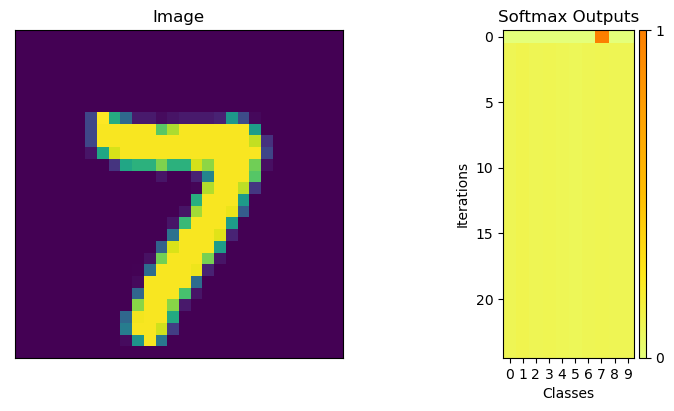

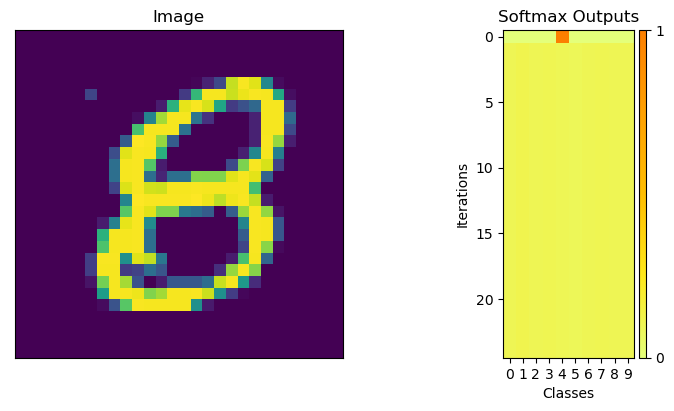

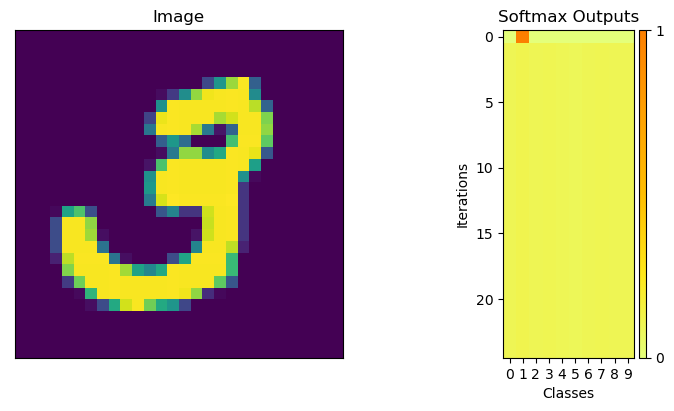

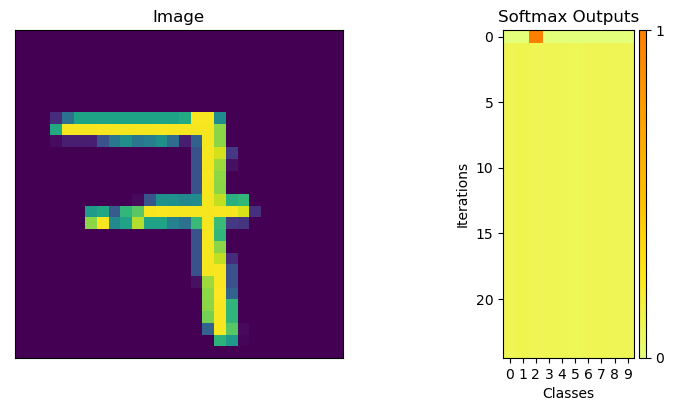

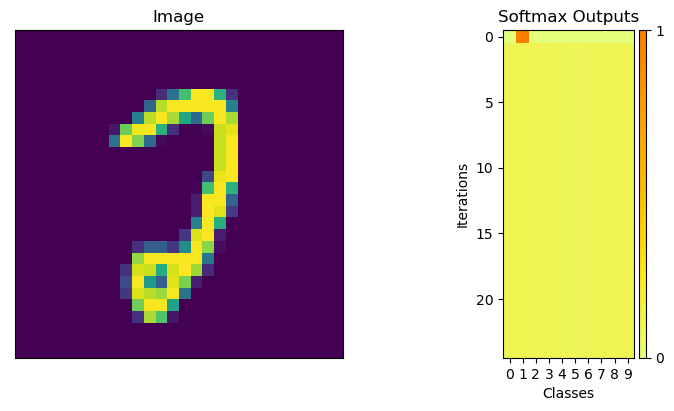

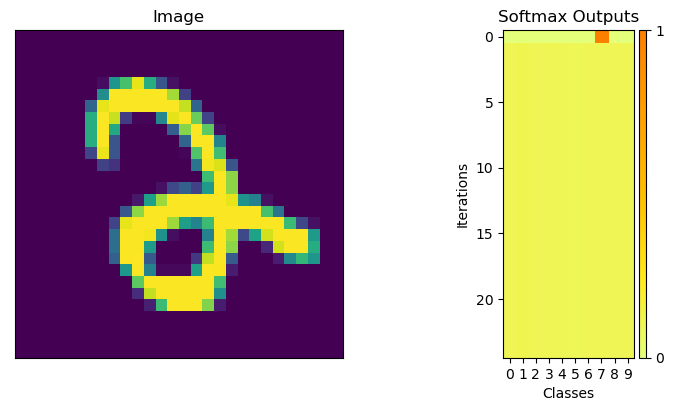

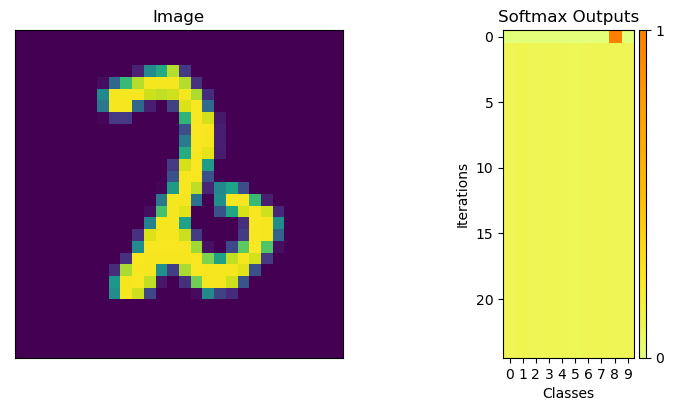

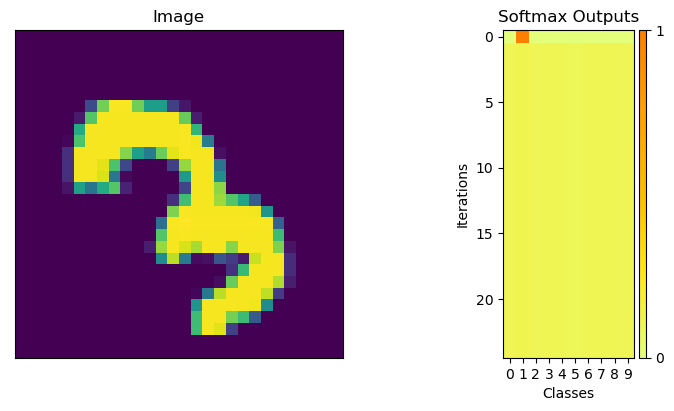

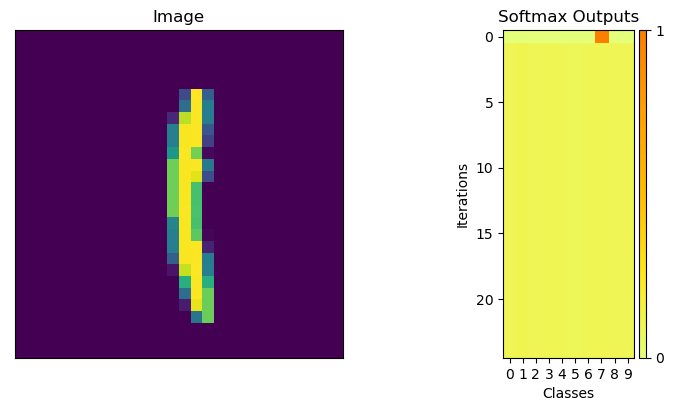

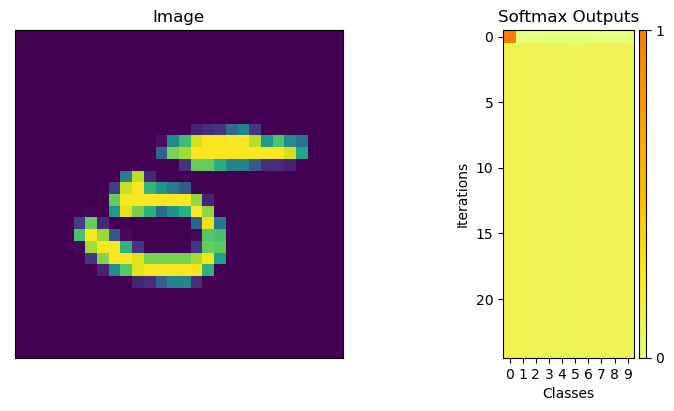

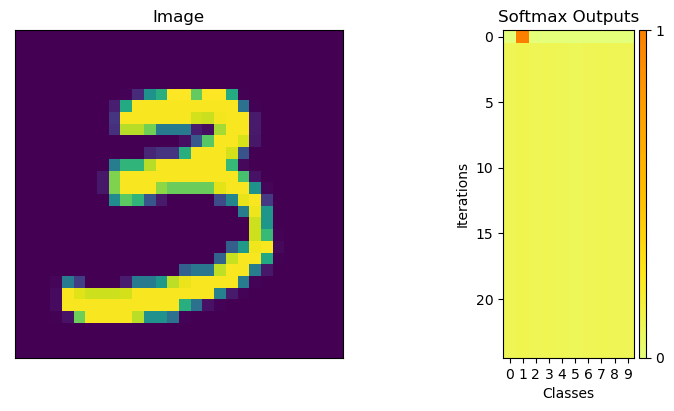

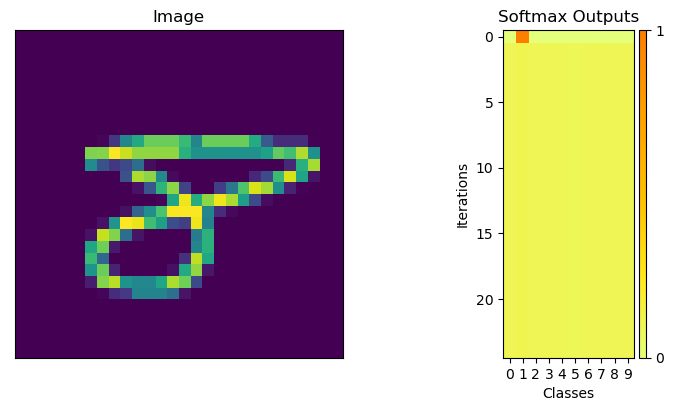

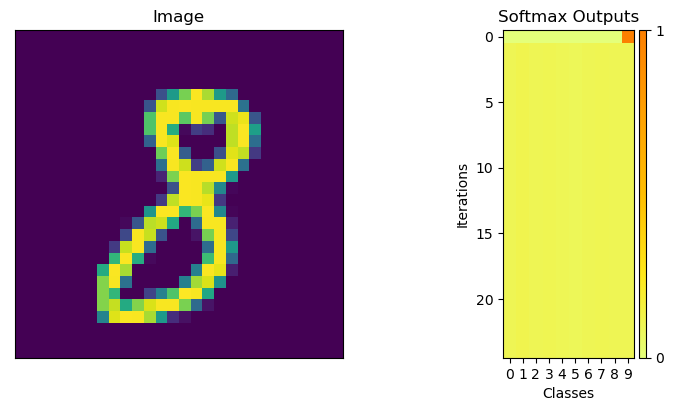

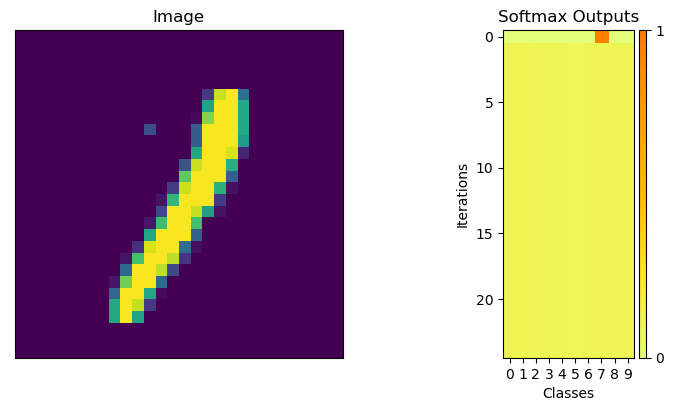

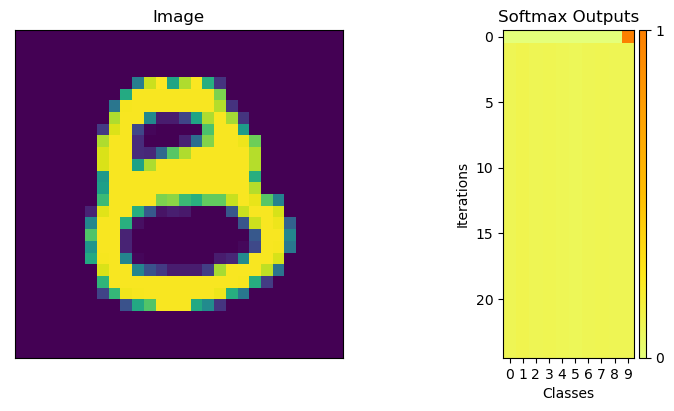

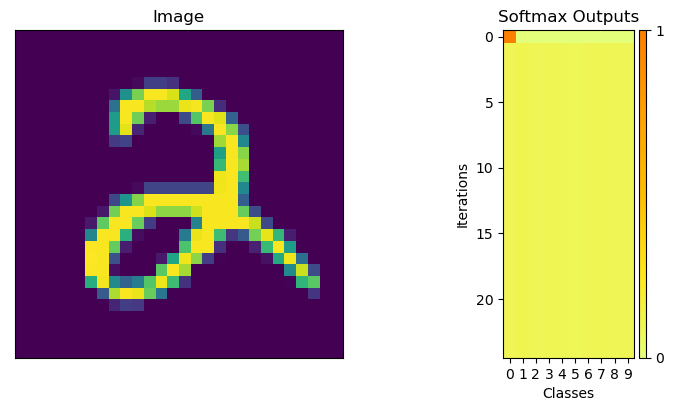

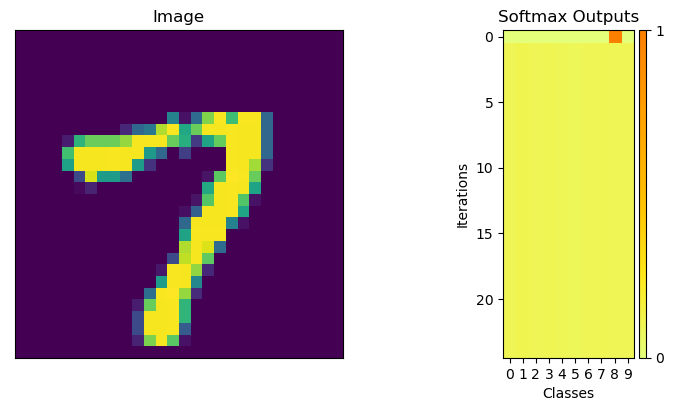

KeyboardInterrupt: 

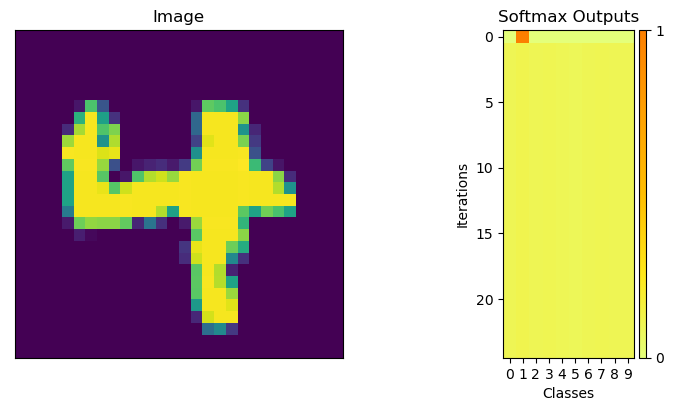

In [6]:
########################
## Visualize N images ##
########################

from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings('ignore')
import matplotlib.backends.backend_pdf

def visualize_softmax(image_idx):

    # visualize each image
    figure = plt.figure(figsize=(40, 40))
    # plot image
    ax1 = figure.add_subplot(8, 8, 1, xticks=[], yticks=[])
    im1 = ax1.imshow(x_train[image_idx])
    ax1.set_title("Image")

    # plot weights graph
    ax2 = figure.add_subplot(8, 8, 2)
    im2 = ax2.imshow(y_hat_train_arr[image_idx, :, :].T, cmap='Wistia')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = figure.colorbar(im2, cax=cax, orientation='vertical', ticks=[0, 1])
    cbar.ax.set_yticklabels(['0', '1'])

    ax2.set(xlabel='Classes', ylabel='Iterations', title='Softmax Outputs')
    ax2.set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax2.set_xticklabels(labels)

    pdf.savefig(figure, bbox_inches='tight')
    plt.show()
        
save_image_path = "/Low_Shot_Outputs/"
pdf = matplotlib.backends.backend_pdf.PdfPages(save_image_path + "sample_200_mock_supervised_softmax_outputs.pdf")
for i in range(200):
    visualize_softmax(np.random.randint(0, y_hat_train_arr.shape[0]))
pdf.close()

# Examine output softmax predictions

In [20]:
print(np.unique(np.argmax(y_hat_train_arr[:, :, 24], axis=1)))

# this shows us that the digit predicted with the highest probability is always 1 for every image in the training set
# not spread equally across all classes -> this is just model bias

[1]


In [24]:
print(np.unique(y_hat_train_arr[:, 1, 24]))

# confirms that the predicted probability that the input image is of class 1 is always the same across all images

[0.11395488]


In [25]:
print(np.unique(y_hat_train_arr[:, 0, 24]))
print(np.unique(y_hat_train_arr[:, 1, 24]))
print(np.unique(y_hat_train_arr[:, 2, 24]))
print(np.unique(y_hat_train_arr[:, 3, 24]))
print(np.unique(y_hat_train_arr[:, 4, 24]))
print(np.unique(y_hat_train_arr[:, 5, 24]))
print(np.unique(y_hat_train_arr[:, 6, 24]))
print(np.unique(y_hat_train_arr[:, 7, 24]))
print(np.unique(y_hat_train_arr[:, 8, 24]))
print(np.unique(y_hat_train_arr[:, 9, 24]))

# confirms that the predicted probabilities for every class is the same regardless of the input images
# the randomization of the labels prevents the model from ever converging in its classification predictions

[0.09940434]
[0.11395488]
[0.10080326]
[0.10237346]
[0.09590343]
[0.08934133]
[0.09873264]
[0.10325432]
[0.09812082]
[0.09811156]
